In [1]:
## Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## LOAD DATA AND EXPLORATORY ANALYSIS

In [3]:
## Load dataset and drop unusefull columns
X_full = pd.read_csv('classes_dataset.csv', dtype={col: np.float32 for col in ['lcc', 'lcom*']})
X_full.shape

(50930, 15)

In [4]:
## Initial data treatment
#X_full.drop(['lcc'], axis=1, inplace=True)
X_full.drop(['refusedBequest'], axis=1, inplace=True)
X_full.drop(['Unnamed: 0'],axis=1,inplace=True)
X_full.dropna(inplace=True)
X_full.shape

(34115, 13)

In [5]:
## Show dataframe header
X_full.head(1)

,dit,fanin,fanout,lcc,lcom*,loc,noc,rfc,innerClassesQty,totalFieldsQty,totalMethodsQty,wmc,godClass
0,4,1,6,0.0,0.592593,39,0,12,0,3,9,10,0


In [6]:
## Is any empty feature?
np.any(np.isnan(X_full))

False

In [7]:
## OUTLIERS EVALUATION

In [155]:
## Function to show boxplot
def plot_boxplot(df):
    df.boxplot()
    plt.grid(False)
    plt.show()

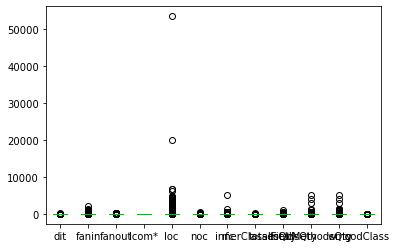

In [156]:
plot_boxplot(X_full)

In [157]:
## Function to return outliers
def outliers(df, ft):
    
    ## first quartile
    Q1 = df[ft].quantile(0.25)
    
    ## third quartile
    Q3 = df[ft].quantile(0.75)
    
    ## calculate interquartile range - distance between quartiles
    IQR = Q3-Q1
    
    ## calculate upper boundary
    UB = Q3 + 1.5 * IQR
    
    ## calculate lower boundary
    LB = Q1 - 1.5 * IQR
    
    ## outliers list
    index_outliers = df.index[ (df[ft] < LB) | (df[ft] > UB) ]
    
    # return indexes list
    return index_outliers

In [158]:
## Create list of outliers, by index
index_list = []
for feature in ['dit', 'fanin', 'fanout', 'lcom*', 'loc', 'noc', 'rfc', 'innerClassesQty', 'totalFieldsQty', 'totalMethodsQty', 'wmc']:
    index_list.extend(outliers(X_full, feature))

In [159]:
## Show index list size
len(index_list)

44094

In [8]:
## SPLIT DATA

In [9]:
## Split dataset in metrics and godsmell ds
X = X_full.drop(['godClass'], axis=1)
y = X_full.godClass

In [10]:
SEED = 0

In [11]:
## Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [12]:
## Show train size
X_train.shape

(27292, 12)

In [13]:
## Show test size
X_test.shape

(6823, 12)

In [165]:
## FIND MOST IMPORTANT FEATURES

In [166]:
## Load libs
from sklearn.ensemble import ExtraTreesRegressor

In [167]:
## Training the model
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

ExtraTreesRegressor()

In [168]:
## Print the importance
reg.feature_importances_

array([0.03845493, 0.05204463, 0.08233825, 0.13389692, 0.12569965,
       0.01724968, 0.13671078, 0.02699322, 0.05091898, 0.07877975,
       0.2569132 ])

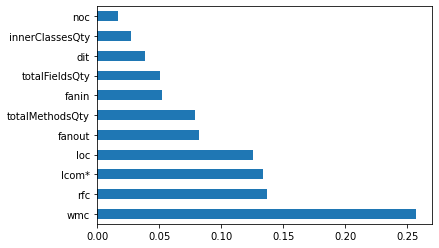

In [169]:
## Importance in bar graph
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

In [14]:
## PIPELINE

In [15]:
## Import descision tree lib
from sklearn.tree import DecisionTreeClassifier

In [16]:
## Create instance
dtreeCLF = DecisionTreeClassifier(random_state=SEED)

In [17]:
pipe = Pipeline(steps=[
            ('minmaxscaler', MinMaxScaler()),
            ('dtreeCLF', dtreeCLF)
    ])

In [18]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'dtreeCLF', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'dtreeCLF__ccp_alpha', 'dtreeCLF__class_weight', 'dtreeCLF__criterion', 'dtreeCLF__max_depth', 'dtreeCLF__max_features', 'dtreeCLF__max_leaf_nodes', 'dtreeCLF__min_impurity_decrease', 'dtreeCLF__min_impurity_split', 'dtreeCLF__min_samples_leaf', 'dtreeCLF__min_samples_split', 'dtreeCLF__min_weight_fraction_leaf', 'dtreeCLF__presort', 'dtreeCLF__random_state', 'dtreeCLF__splitter'])

In [19]:
# 1.024 possibilities
parameters = dict(
    dtreeCLF__max_depth = list(range(1, 33)),
    dtreeCLF__min_samples_split = [32,64,128,256],
    dtreeCLF__min_samples_leaf = [32,64,128,256],
    dtreeCLF__criterion = ["gini", "entropy"]
)

In [20]:
## TUNING THE MODEL

In [21]:
## Import libs
from sklearn.model_selection import RandomizedSearchCV, KFold

In [22]:
## Randomized Search Instance
randomized_search = RandomizedSearchCV(pipe,parameters,cv = KFold(n_splits=10),n_iter=100,random_state=SEED,scoring='neg_mean_squared_error')

In [23]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('dtreeCLF',
                                              DecisionTreeClassifier(random_state=0))]),
                   n_iter=100,
                   param_distributions={'dtreeCLF__criterion': ['gini',
                                                                'entropy'],
                                        'dtreeCLF__max_depth': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                11, 12, 13, 14,
                                                                15, 16, 17, 18,
                                                                19, 20, 21, 22,
                                                                23, 24, 25, 26,
                                        

In [24]:
resultados = pd.DataFrame(randomized_search.cv_results_)
resultados.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtreeCLF__min_samples_split,param_dtreeCLF__min_samples_leaf,param_dtreeCLF__max_depth,param_dtreeCLF__criterion,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035076,0.008904,0.007002,0.007540,256,256,26,entropy,"{'dtreeCLF__min_samples_split': 256, 'dtreeCLF...",-0.025275,...,-0.020520,-0.022353,-0.02052,-0.024185,-0.019787,-0.026017,-0.017955,-0.022058,0.002731,78
1,0.023680,0.007709,0.001713,0.004659,256,128,2,gini,"{'dtreeCLF__min_samples_split': 256, 'dtreeCLF...",-0.025275,...,-0.018322,-0.021253,-0.02052,-0.022719,-0.019421,-0.020154,-0.028215,-0.021984,0.003131,77


In [25]:
## Print best params
randomized_search.best_params_

{'dtreeCLF__min_samples_split': 128,
 'dtreeCLF__min_samples_leaf': 32,
 'dtreeCLF__max_depth': 26,
 'dtreeCLF__criterion': 'gini'}

In [26]:
## Print best score
randomized_search.best_score_

-0.014986060720762076

In [27]:
## TRAINING THE BEST MODEL

In [28]:
## Traning best model
tuned_hyper_model= DecisionTreeClassifier(random_state=SEED, criterion='gini', min_samples_split=128, min_samples_leaf=32, max_depth=26)
tuned_hyper_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=26, min_samples_leaf=32, min_samples_split=128,
                       random_state=0)

In [29]:
tuned_hyper_model.feature_importances_

array([5.37173993e-05, 8.28339271e-02, 8.76424161e-03, 0.00000000e+00,
       1.08684831e-01, 1.88424682e-03, 0.00000000e+00, 5.22426634e-02,
       1.40715665e-03, 2.17767736e-02, 5.40479196e-03, 7.16947651e-01])

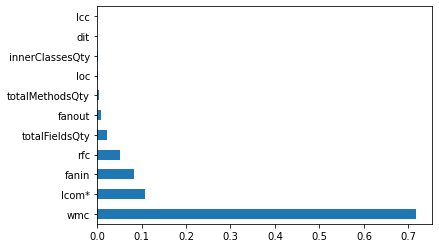

In [30]:
feat_importances = pd.Series(tuned_hyper_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

In [31]:
## Prediction
y_pred=tuned_hyper_model.predict(X_test)

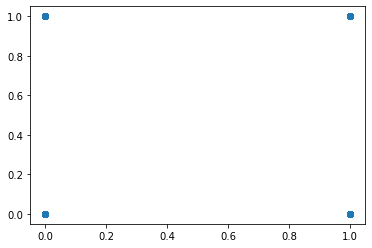

In [32]:
## Plot result
plt.scatter(y_test,y_pred)

In [33]:
## EVALUATE

In [34]:
## Evaluate error rate
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.016561629781620988
MSE: 0.016561629781620988
RMSE: 0.12869199579469187


In [35]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [36]:
accuracy_score(y_test, y_pred.round())

0.983438370218379

In [37]:
precision_score(y_test, y_pred.round())

0.6810035842293907

In [38]:
recall_score(y_test, y_pred.round())

0.8878504672897196

In [39]:
f1_score(y_test, y_pred.round())

0.7707910750507099